# ceLEry Analysis: 2D Coordinates Recovery of Single Cells

## Xenium Breast Cancer, InSitu Replicate 1


https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer



### 1. Import Packages

In [1]:
import os,csv,re
import pandas as pd
import numpy as np

import math
from sklearn.cluster import KMeans

from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import pickle

import scanpy as sc
import anndata as ad
from scipy import sparse
from anndata import AnnData
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Read original data and save it to h5ad
from scanpy import read_10x_h5

/Users/ameliaschroeder/miniconda3/envs/Celery/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#import sys
#sys.path.append('/lustre03/project/6075067/calcium/2021/CeLEry/CeLEry_package')

import CeLEry as cel

### 2. Load Data

In [3]:
#Read in gene expression and spatial location
os.chdir("")
adata = read_10x_h5("Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
spatial_full = pd.read_csv("Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv",sep=",",na_filter=False,index_col=0)

In [4]:
# cells to be filtered out based on total UMI and number of genes expressed
os.chdir("")
lowUMI_cellID = pd.read_csv("cell_ID_toRemove_filtered_75_25.csv",sep=",",na_filter=False,index_col=0)

In [5]:
adata

AnnData object with n_obs × n_vars = 167782 × 313
    var: 'gene_ids', 'feature_types', 'genome'

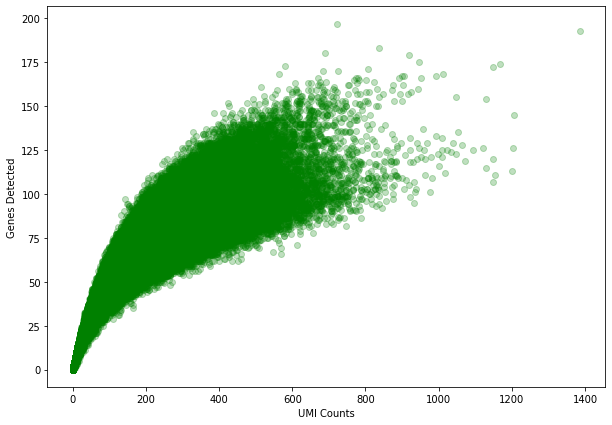

In [6]:
# How many genes are expressed in each of the cells

# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
plt.show()


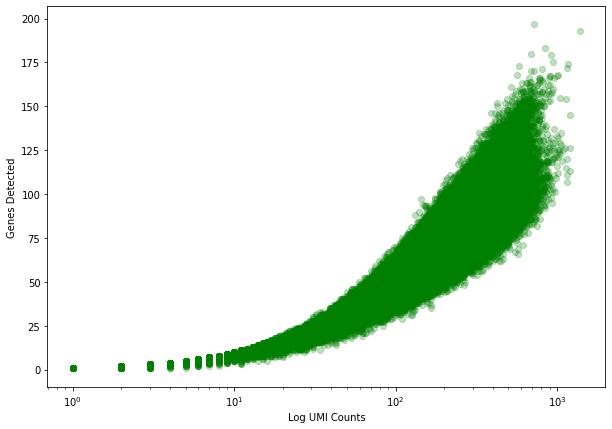

In [7]:
# How many genes are expressed in each of the cells


# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("Log UMI Counts")
ax.set_ylabel("Genes Detected")


ax.set_xscale('log')

plt.show()


In [8]:
spatial_full

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
cell_id,,,,,,,,
1,377.663005,843.541888,154,0,0,154,110.361875,45.562656
2,382.078658,858.944818,64,0,0,64,87.919219,24.248906
3,319.839529,869.196542,57,0,0,57,52.561875,23.526406
4,259.304707,851.797949,120,0,0,120,75.230312,35.176719
5,370.576291,865.193024,120,0,0,120,180.218594,34.499375
...,...,...,...,...,...,...,...,...
167778,7455.404785,5115.021094,238,1,0,239,219.956094,61.412500
167779,7483.771045,5111.720703,80,0,0,80,38.427969,25.964844
167780,7470.119580,5119.350366,406,0,0,406,287.690469,86.158125


In [ ]:
low_UMI_names = adata.obs_names[list(lowUMI_cellID['x']-1)]

In [10]:
# The pixel size of Xenium 0.2125 microns. 
# Coordinates in microns from cells.csv.gz can be converted to pixel coordinates 
# by dividing by the pixel size. The origin of the coordinate system is the upper left of the TIFF image.


pixel_size = 0.2125

spatial = pd.DataFrame()
spatial['0'] = spatial_full.x_centroid
spatial['1'] = [1] * 167782
spatial['2'] = spatial_full.x_centroid
spatial['3'] = spatial_full.y_centroid 
spatial['4'] = spatial_full.x_centroid / pixel_size
spatial['5'] = spatial_full.y_centroid / pixel_size

b = ['CellID '] * 167782
a = list(range(1,167783))

#spatial.index = [m+str(n) for m,n in zip(b,a)]

spatial.index = spatial.index.astype('str')


spatial = spatial.drop(['0'], axis = 1)
spatial.index.name = '0'
spatial.columns = spatial.columns.astype('int64')

spatial = spatial.astype('int64')

adata.obs_names = spatial.index.astype('str')

In [15]:
TrainDatafull = cel.make_annData_spatial(adata, spatial, filtered = True)


In [16]:
TrainDatafull.obs

,select,x_cord,y_cord,x_pixel,y_pixel,n_counts
0,,,,,,
1,1,377,843,1777,3969,154.0
2,1,382,858,1798,4042,64.0
3,1,319,869,1505,4090,57.0
4,1,259,851,1220,4008,120.0
5,1,370,865,1743,4071,120.0
...,...,...,...,...,...,...
167778,1,7455,5115,35084,24070,238.0
167779,1,7483,5111,35217,24055,80.0
167780,1,7470,5119,35153,24091,406.0


In [17]:
TrainDatafull = adata.copy()
TrainDatafull.var['genename'] = TrainDatafull.var.gene_ids
TrainDatafull

AnnData object with n_obs × n_vars = 166313 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

### 3. Filter out cells with low UMI and low number of genes expressed

In [35]:
os.chdir("")
TrainDatafull.obs_names = TrainDatafull.obs_names.astype(np.int64) 

TrainDatafull_filtered = TrainDatafull.copy()[~TrainDatafull.obs_names.isin(lowUMI_cellID.x), :]
TrainDatafull_filtered

View of AnnData object with n_obs × n_vars = 42228 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

Then, we continue to analyze the data. We standardize the data set into z-score to remove the potential batch effect.

In [25]:
## Calculating z-score
cel.get_zscore(TrainDatafull_filtered)

### 4. Split data into train and test data 

In [73]:
### Spliting into training and testing data for prediction/evalutaiton:
random.seed(2023)
np.random.seed(2023)

index90 = random.sample(range(TrainDatafull_filtered.shape[0]), int(TrainDatafull_filtered.shape[0]*0.1))

In [86]:
# split the data into training and testing data (90% train, 10% test)

# 90% train
DataSubtrain90_coor = TrainDatafull_filtered[list(set(range(TrainDatafull_filtered.shape[0]))-set(index90)),]

# 10% holdoff
DataSubtest10_coor = TrainDatafull_filtered[list(set(index90)),]


In [87]:
DataSubtrain90_coor


View of AnnData object with n_obs × n_vars = 38006 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

In [88]:
DataSubtrain90_coor.obs

,select,x_cord,y_cord,x_pixel,y_pixel,n_counts
0,,,,,,
7,1,296,856,1394,4031,473.0
32,1,277,856,1306,4029,298.0
54,1,182,852,856,4013,294.0
55,1,132,864,623,4069,488.0
59,1,148,843,696,3968,332.0
...,...,...,...,...,...,...
167761,1,7486,5212,35231,24531,267.0
167771,1,7458,5095,35099,23977,305.0
167772,1,7469,5093,35148,23970,391.0


In [90]:
DataSubtest10_coor.obs

,select,x_cord,y_cord,x_pixel,y_pixel,n_counts
0,,,,,,
65987,1,2432,486,11449,2289,382.0
66022,1,2192,579,10319,2728,283.0
66024,1,2187,586,10293,2758,297.0
99590,1,3777,1334,17778,6279,346.0
66029,1,2234,590,10513,2780,342.0
...,...,...,...,...,...,...
135729,1,5105,4791,24026,22547,330.0
99565,1,3762,1397,17705,6576,315.0
35023,1,414,3518,1951,16558,512.0


In [45]:
## Export the cell barcodes used in the training and test set (for comparable results with the competing methods)

trainCell_index = pd.DataFrame(DataSubtrain90_coor.obs.index.astype('int64'))
testCell_index = pd.DataFrame(DataSubtest10_coor.obs.index.astype('int64'))

os.chdir("") #scheme 4
trainCell_index.to_csv("trainCell_index.csv")
testCell_index.to_csv("testCell_index.csv", sep=',')



### 5. Run CeLerY: Analysis Task: 2D Coordinates Recovery of Single Cells

##### Note: We found in our benchmarking that spots with VERY LOW total UMI count tend to have VERY HIGH euclidean distance between the true and predicted coordinates

In [46]:
output_path_coors = ""

### Fit model to reference data

In [1]:
### Fit model using  Replicate 1

model_train = cel.Fit_cord (data_train = DataSubtrain90_coor, location_data = DataSubtrain90_coor.obs[["x_pixel","y_pixel"]], hidden_dims = [30, 25, 15,10], num_epochs_max = 1000, path = output_path_coors, batch_size = 64, filename = "Org_BreastCancer10XAnnotated_Rep1")



### Recover coordinates of holdout cells:

In [54]:
os.chdir(output_path_coors)
cords_predXenium = cel.Predict_cord(DataSubtest10_coor, path = output_path_coors, filename = "Org_BreastCancer10XAnnotated_Rep1")



### 6.  Analyze Results

In [48]:
import math
def covertCoords (coords, referlocation, filename = None):
    plt.figure()
    referx = referlocation.iloc[:,0]
    refery = referlocation.iloc[:,1]
    referxmin = referx.min()
    referxmax = referx.max()
    referymin = refery.min()
    referymax = refery.max()
    xlen = referxmax - referxmin + 1
    ylen = referymax - referymin + 1
    pixel_pred = pd.DataFrame()
    for inp in range(coords.shape[0]):
        x_pixel_pred = math.floor(coords[inp,0]*xlen)
        y_pixel_pred = math.floor(coords[inp,1]*ylen)
        xvalues = [referx[inp]- referxmin,x_pixel_pred]
        yvalues = [refery[inp]- referymin,y_pixel_pred]
        plt.plot(yvalues, xvalues, color = "#555b6e", alpha = 0.5, lw = 0.8)
        df_pred = pd.DataFrame([[x_pixel_pred,y_pixel_pred]],columns=list('XY'), index=[inp])
        pixel_pred = pixel_pred.append(df_pred)
    return(pixel_pred)

In [58]:
DataSubtest10_coor

AnnData object with n_obs × n_vars = 4222 × 313
    obs: 'select', 'x_cord', 'y_cord', 'x_pixel', 'y_pixel', 'n_counts', 'x_cord_pred', 'y_cord_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'log1p'

### Relocation Plot: 

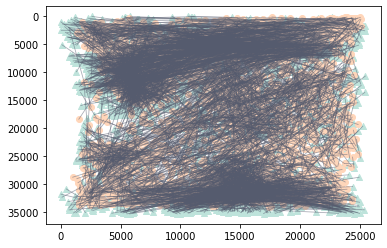

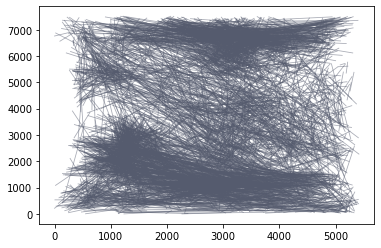

In [50]:
cel.RelocationPlot(cords_predXenium, DataSubtest10_coor.obs[["x_pixel","y_pixel"]])
covertCoords_pred_10 = covertCoords(cords_predXenium, DataSubtest10_coor.obs[["x_cord","y_cord"]])
